# $k$-means Clustering

## Introduction

$k$-means clustering is a classical problem in data science. It consists in finding a partition of a given set of observations into a given number of clusters.

![Example](data.png "Before k_means")

<div style="text-align: center;">
    <img src="arrow.png" alt="Arrow" style="width: 100px; height: auto; margin-left: -150px;">
</div>

![Example](clusterdata.png "After k_means")


## Notebook installation requirements 

In [1]:
import subprocess
import sys

def install_requirements():
    try:
        with open('requirements.txt') as f:
            packages = f.read().splitlines()
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-r', 'requirements.txt'])
        print("All packages have been successfully installed.")
    except Exception as e:
        print(f"An error occurred while installing the packages: {e}")

install_requirements()

All packages have been successfully installed.


## Problem description

**Inputs**
* $N$ observations with their coordinates $X_i$, $i = 1, \dots, N$ in the considered space
* A number of clusters to build $K$.

**Problem**: partition the $N$ observations into $K$ clusters such that each observations belongs to exactly one cluster.

**Objective**: minimize the total sum of euclidean distances between each observation and the center of its cluster

$$
\min \sum_{k=1}^K \sum_{i \in \mathrm{cluster_k}} \| X_i - c_k \|^2_2
$$
with $c_k$ the coordinates of the center of cluster $k$.

## Resolution with Scikit-learn

$k$-means clustering being a classical problem in data science, algorithms to solve it are already available. For example, in Python, Scikit-learn offers an algorithm to solve $k$-means clustering problems.

First, let's generate some data:

In [2]:
import pandas as pd 
import numpy as np

data = pd.read_csv('kmeans.csv')
print(data)

C:\Users\ffontan\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\ffontan\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


             X          Y
0     2.072345  -3.241693
1    17.936710  15.784810
2     1.083576   7.319176
3    11.120670  14.406780
4    23.711550   2.557729
..         ...        ...
295  12.731310   7.050802
296   8.388222  23.453470
297  23.427080   4.598641
298   4.046104   7.634936
299   7.667025   3.193633

[300 rows x 2 columns]


In [3]:
X = data['X'].values
Y = data['Y'].values 
observations_positions = np.array(list(zip(X,Y)))
nb_observations = len(observations_positions)
nb_clusters = 3

Let's plot this data:

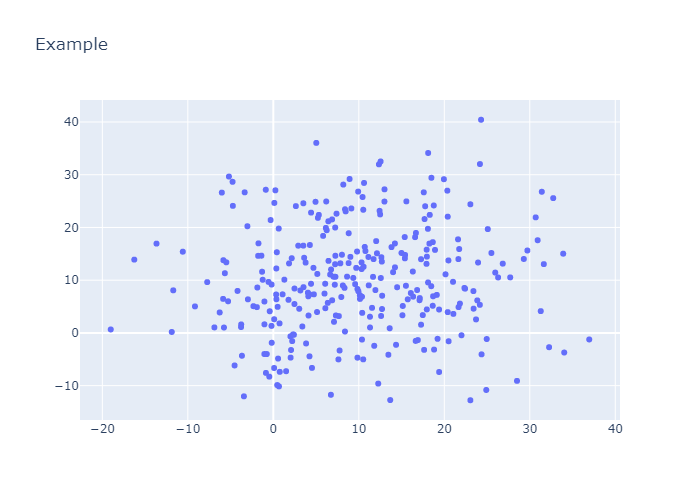

In [4]:
import plotly.graph_objects as go

def draw_data(observations_positions,name):
    nb_observations = len(observations_positions)
    fig = go.Figure()
    fig.add_scatter(x = [observations_positions[i][0] for i in range(nb_observations)], y =  [observations_positions[i][1] for i in range(nb_observations)], mode ='markers', name="Observations")
    fig.update_layout(
        title = name,
                )
    fig.show("png")

draw_data(observations_positions, "Example")

Now, let's, solve the problem using the algorithm from Scikit-learn:

In [5]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0).fit(observations_positions)

Let's visualize the solution:

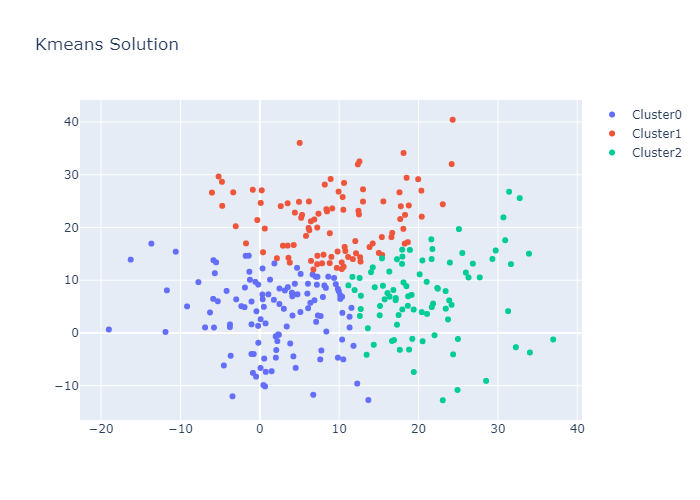

Total cost (which is the total sum of euclidean distances between each observation and the center of its cluster): 26236.67493465098


In [6]:
fig_sk = go.Figure()
for j in range(nb_clusters):
    fig_sk.add_scatter(x = [observations_positions[i][0] for i in range(nb_observations) if (kmeans.labels_[i] == j)], y =  [observations_positions[i][1] for i in range(nb_observations) if (kmeans.labels_[i] == j)], mode ='markers', name=f"Cluster{j}")

fig_sk.update_layout(
        title = "Kmeans Solution",
                )

fig_sk.show("png")
print(f"Total cost (which is the total sum of euclidean distances between each observation and the center of its cluster): {kmeans.inertia_}")

## Mathematical model
Now, we show how to model the $k$-means clustering problem using nonlinear programming.

Variables:

* $a^k_i \in \{ 0 , 1\}$,  $i = 1, \dots, N$, $k = 1, \dots, K$: a boolean variable which is 1 if the observation $i$ is in cluster $k$: else 0 .
* $d^k_i \in \mathbb{R^+}$, $i = 1, \dots, N$, $k = 1, \dots, K$: a positive variable which represents the euclidian squared distance between observation i and cluster k.
* $b^k \in \mathbb{R^2}$,  $k = 1, \dots, K$: position of the barycenter of the cluster k. 

Objective:
$$
\min \sum_{i=1}^N{\sum_{k=1}^K}{a^k_id^k_i}
$$

Constraints:
* Each observation has to be in one cluster
$$
\forall i = 1, \dots, N \qquad\sum_{k=1}^K{a^k_i}= 1
$$
* Mathematically the barycenter of cluster k has the following formula
$$
\forall k = 1, \dots, K \qquad b_k\sum_{i=1}^N{a^k_i}= \sum_{i=1}^N{X_i}a^k_i 
$$
* Square distance formula
$$
\forall i = 1, \dots, N, \forall k = 1, \dots, K, \qquad d^k_i = \| X_i - b_k \|^2_2
$$

# Implementation with Pyomo

Now, let's write the model with the modeler Pyomo.


In [7]:
import pyomo.environ as pyo

def build_model(nb_observations, nb_clusters):

    ####################
    # Create variables #
    ####################
    
    model.N = pyo.RangeSet(0, nb_observations - 1)
    model.K = pyo.RangeSet(0, nb_clusters - 1)
    model.a = pyo.Var(model.N, model.K, within = pyo.Binary)
    model.d = pyo.Var(model.N, model.K, within = pyo.NonNegativeReals)
    # bx & by (abcissa and ordinate)
    model.bx = pyo.Var(model.K, within = pyo.Reals)
    model.by = pyo.Var(model.K, within = pyo.Reals)
    
    #############
    # Objective #
    #############
    
    model.objective = pyo.Objective(
                expr= pyo.quicksum(model.a[s,t]* model.d[s,t]
                                   for s in model.N
                                   for t in model.K),
                sense=pyo.minimize)
    
    ###############
    # Constraints #
    ###############
    
    
    def one_cluster_rule(model,i):
        total = 0
        for j in range(nb_clusters):
            total += model.a[i,j]
        return (total == 1)
    model.constraints_one_cluster = pyo.Constraint(model.N, rule=one_cluster_rule)
    
    def barycenter_x_position_rule(model, j):
        total_a = 0 
        total_pa_x = 0
        for i in range(nb_observations):
             total_a += model.a[i,j]
             total_pa_x += model.a[i,j]*observations_positions[i][0]
        total_b_x = (1/total_a)*total_pa_x
        return (total_b_x == model.bx[j])
    model.constraints_barycenter_x_position_rule = pyo.Constraint(model.K,rule=barycenter_x_position_rule)
    
    def barycenter_y_position_rule(model, j):
        total_a = 0 
        total_pa_y = 0
        for i in range(nb_observations):
             total_a += model.a[i,j]
             total_pa_y += model.a[i,j]*observations_positions[i][1]
        return (total_pa_y == total_a*model.by[j])
    model.constraints_barycenter_y_position_rule = pyo.Constraint(model.K,rule=barycenter_y_position_rule)

    def dist_rule(model,s,t):
        return (model.d[s,t] == (((observations_positions[s][0]-model.bx[t])**2)  +
                                                         ((observations_positions[s][1]-model.by[t])**2)))

    model.constraints_dist_rule = pyo.Constraint(model.N,model.K,rule=dist_rule)

# Let's build the model and run it 
model = pyo.ConcreteModel()
build_model(nb_observations,nb_clusters)
solver = pyo.SolverFactory('knitroampl')
results = solver.solve(model, tee=True)

Artelys Knitro 14.1.0: 
          Commercial License
         Artelys Knitro 14.1.0

No start point provided -- Knitro computing one.

         The Knitro mixed integer solver is designed for convex problems.
         For non-convex problems it is only a heuristic, and the reported
         bounds and optimality claims cannot be verified.

concurrent_evals         0
datacheck                0
hessian_no_f             1
hessopt                  1
Knitro changing mip_method from AUTO to 1.
Knitro changing mip_rootalg from AUTO to 1.
Knitro changing mip_lpalg from AUTO to 3.
Knitro changing mip_branchrule from AUTO to 2.
Knitro changing mip_selectrule from AUTO to 2.
Knitro changing mip_mir from AUTO to 2.
Knitro changing mip_clique from AUTO to 0.
Knitro changing mip_zerohalf from AUTO to 0.
Knitro changing mip_liftproject from AUTO to 0.
Knitro changing mip_knapsack from AUTO to 2.
Knitro changing mip_gomory from AUTO to 0.
Knitro changing mip_cut_flowcover from AUTO to 2.
Knitro changi

   70        61211.3         0.307983           1063.63       3.708
   71        61139.1          1.08977           1067.56       3.745
   72        61047.1         0.751440           843.591       3.791
   73        60830.8         0.152548           150.403       3.898
   74        60135.1          1.33373           52.1335       3.982
   75        60099.2          1.17683           41.6865       4.096
   76        59033.4          10.9749           190.205       4.175
   77        58801.4          6.09427           159.652       4.281
   78        58460.1          5.52948           83.4791       4.347
   79        58413.0          4.05724           103.097       4.430
   80        58214.0          3.71047           66.2923       4.544
   81        58194.0          1.39768           94.1892       4.629
   82        57448.9          1.34708           184.835       4.732
   83        57263.3         0.720130           164.924       4.841
   84        56949.8         0.185039           

  193        37010.9         0.878261           50.8550      18.344
  194        36933.0         0.843682           46.7550      18.413
  195        36588.1          1.26131           85.3282      18.477
  196        36325.4          1.14475           76.9059      18.569
  197        36130.5          1.11285           81.1094      18.635
  198        35929.3         0.967959           23.1532      18.735
  199        35872.6         0.941739           16.6014      18.800
  200        35817.5      2.12106e-03           16.8807      18.874
  201        35578.1         0.151890           34.5726      18.969
  202        35389.1         0.173672           38.1652      19.036
  203        35026.4         0.410493           60.1402      19.131
  204        34898.1         0.420870           47.6855      19.194
  205        34885.8      1.77473e-03           13.6791      19.269
  206        34787.8      2.76033e-02           15.2395      19.358
  207        34682.8      7.17638e-03           

  316        28151.2      2.93964e-02           34.4144      26.400
  317        28123.2      5.91373e-02           41.1575      26.500
  318        28111.2      6.67361e-02           25.2977      26.561
  319        28107.8      5.89960e-02           21.9724      26.623
  320        28107.7      4.75985e-02           18.6445      26.658
  321        28097.9      5.70892e-02           31.6407      26.692
  322        28086.1      2.16368e-02           37.6997      26.775
  323        28042.8      4.94774e-02           46.6523      26.839
  324        28039.6      4.02821e-02           14.1750      26.933
  325        28006.5      7.39538e-02           36.0999      26.999
  326        28000.4      7.11385e-02           37.3012      27.065
  327        27990.7      5.64755e-02           39.6180      27.164
  328        27978.2      5.86361e-02           14.6335      27.230
  329        27976.6      5.40133e-02           14.1244      27.318
  330        27976.4      2.32107e-03           

  438        26323.6      3.73402e-02           7.03172      37.781
  439        26323.4      1.50655e-02           7.04586      37.830
  440        26320.0      8.57471e-03           9.84456      37.975
  441        26310.8      4.29899e-02           19.7889      38.064
  442        26310.7      4.23669e-02           19.4479      38.115
  443        26310.6      1.52814e-02           12.3314      38.185
  444        26307.3      2.65603e-02           7.41990      38.234
  445        26307.3      2.39303e-02           5.20173      38.306
  446        26307.7      4.22686e-04           2.57968      38.360
  447        26306.2      2.34401e-03           5.01069      38.429
  448        26305.8      2.51317e-03           3.82181      38.478
  449        26299.5      5.34544e-02           11.7910      38.528
  450        26299.5      5.23149e-02           9.47372      38.556
  451        26290.3      6.69298e-02           27.6700      38.584
  452        26288.7      3.61494e-02           



# Comparison with Scikit-learn

Let's visualize the solution and compare it with the classic Kmeans Algorithm.

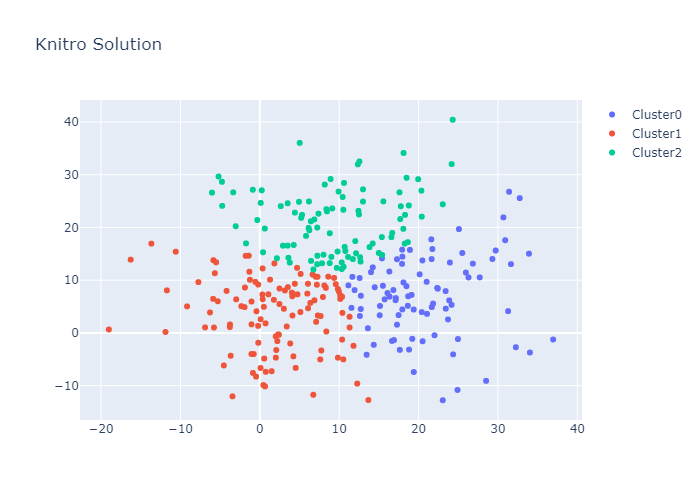

Le cluster 0 admet 88 nombre d'observations
Le cluster 1 admet 117 nombre d'observations
Le cluster 2 admet 95 nombre d'observations
Total cost is 26235.011222378937


In [8]:
def draw_figure(nb_observations,nb_clusters,model,name):
    fig = go.Figure()
    for j in range(nb_clusters):
        fig.add_scatter(x = [observations_positions[i][0] for i in range(nb_observations) if (model.a[i,j]() > 0.99)], y =  [observations_positions[i][1] for i in range(nb_observations) if (model.a[i,j]() > 0.99)], mode ='markers', name=f"Cluster{j}")
    fig.update_layout(
        title = name,
                )
    fig.show("png")
    
    for j in range(nb_clusters):
        total = 0
        for i in range(nb_observations):
            if(model.a[i,j]() > 0.99):
                total += 1
        print(f"Le cluster {j} admet {total} nombre d'observations") 
    
    print(f"Total cost is {model.objective()}")

draw_figure(nb_observations,nb_clusters,model, "Knitro Solution")

Nonlinear programming is significantly slower than the algorithm implemented in Sciki-learn. However, it finds a better solution ($26235.01 < 26243.6$) on the considered instance.

In the next section, we will see that another advantage of nonlinear programming is when additional constraints need to be taken into account.

# Model Extensions

In some cases, additional constraints must be taken into account. These extensions are usually not supported by the algorithms available in the data science libraries. Here we illustrate 3 of these additional constraints and how to model them with nonlinear programming:
* Force some pairs of observations to be in the same cluster
* Force some pairs of observations to be in different clusters
* Impose a minimum and maximum sizes for clusters

## Cannot-link and must-link observations

### Problem description

In some cases, some pairs of observations might be known to belong to the same cluster or to different clusters. These are called "must-link" and "cannot-link" constraints.

Let $P^\text{must}$ be the set of set of observations that must belong to the same cluster.

Let $P^\text{cannot}$ be the set of pairs of observations that must belong to different clusters.

### Input data

The input data of observations is the same as for the previous example. We just need to specify must-link observations or cannot-link observations (between two observations which should not be linked)

#### Must-link observations

In [9]:
must_link_g1 = []
must_link_g2 = []
cannot_link = []

for k in range(nb_observations):
    if(0 < observations_positions[k][0] < 10 and observations_positions[k][1] >= 20):
        must_link_g1.append(k)
    if (10 < observations_positions[k][0] < 20 and observations_positions[k][1] >= 20):
        must_link_g2.append(k)
    if( observations_positions[k][0] == 8.9204 or observations_positions[k][0] == 10.61132):
        cannot_link.append(k)
print(cannot_link)

[22, 247]


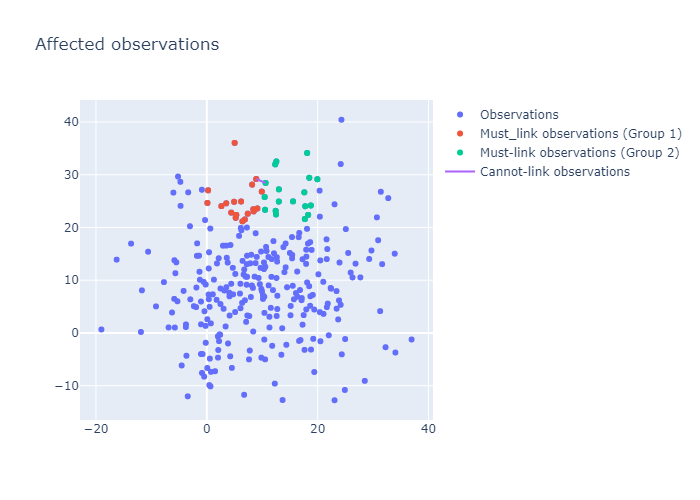

In [10]:
fig = go.Figure()
fig.add_scatter(x = [observations_positions[i][0] for i in range(nb_observations)], y =  [observations_positions[i][1] for i in range(nb_observations)], mode ='markers', name="Observations")
fig.add_scatter(x = [observations_positions[i][0] for i in must_link_g1], y =  [observations_positions[i][1] for i in must_link_g1], mode ='markers', name="Must_link observations (Group 1)")
fig.add_scatter(x = [observations_positions[i][0] for i in must_link_g2], y =  [observations_positions[i][1] for i in must_link_g2], mode ='markers', name="Must-link observations (Group 2)")
fig.add_scatter(x = [observations_positions[i][0] for i in cannot_link], y =  [observations_positions[i][1] for i in cannot_link], mode ='lines', name="Cannot-link observations")
fig.update_layout(
    title = "Affected observations",
            )
fig.show("png")

All red/green elements should be in the same cluster. Moreover, the linked observations should not be in the same cluster.

### Mathematical model

We add the two following set of constraints to the previous mathematical model.

* Must-link constraints

$$
\forall k = 1, \dots, K, \quad \forall S \in P^\text{must}, \quad \forall i \in S, \qquad a^k_{i} = a^k_{S[0]} 
$$

* Cannot-link constraints

$$
\forall k = 1, \dots, K, \quad \forall i_1, i_2 \in P^\text{cannot}, \qquad a^k_{i_1} + a^k_{i_2} \leq 1
$$

### Implementation with Pyomo

In [11]:
model.MLG1 = pyo.Set(initialize = must_link_g1)
model.MLG2 =pyo.Set(initialize = must_link_g2)
model.CL = pyo.Set(initialize = cannot_link)

def cannot_link_rule(model,i,p,j):
    if (i != p):
        return(model.a[i,j] + model.a[p,j] <= 1)
    else:
        return(model.a[i,j] == model.a[p,j])
model.constraints_cannot_link = pyo.Constraint(model.CL,model.CL,model.K,rule=cannot_link_rule)

def must_link_rule_g1(model,i,j):
    return(model.a[i,j] == model.a[must_link_g1[0],j])
model.constraints_must_link_g1 = pyo.Constraint(model.MLG1,model.K,rule=must_link_rule_g1)

def must_link_rule_g2(model,i,j):
    return(model.a[i,j] == model.a[must_link_g2[0],j])
model.constraints_must_link_g2 = pyo.Constraint(model.MLG2,model.K,rule=must_link_rule_g2)

    
#Run with new constraints 
solver = pyo.SolverFactory('knitroampl')
results = solver.solve(model, tee=True)

Artelys Knitro 14.1.0: WARNING: 12 constraints are constant or undefined and will be ignored.

          Commercial License
         Artelys Knitro 14.1.0

MINLP solver shifted start point to satisfy bounds (146 variables).
         The Knitro mixed integer solver is designed for convex problems.
         For non-convex problems it is only a heuristic, and the reported
         bounds and optimality claims cannot be verified.

concurrent_evals         0
datacheck                0
hessian_no_f             1
hessopt                  1
Knitro changing mip_method from AUTO to 1.
Knitro changing mip_rootalg from AUTO to 1.
Knitro changing mip_lpalg from AUTO to 3.
Knitro changing mip_branchrule from AUTO to 2.
Knitro changing mip_selectrule from AUTO to 2.
Knitro changing mip_mir from AUTO to 2.
Knitro changing mip_clique from AUTO to 0.
Knitro changing mip_zerohalf from AUTO to 0.
Knitro changing mip_liftproject from AUTO to 0.
Knitro changing mip_knapsack from AUTO to 2.
Knitro changing m

   68        32024.5         0.720454           5.85371       3.536
   69        32010.2         0.721004           4.92781       3.580
   70        31951.3         0.732635           5.97988       3.629
   71        32205.9         0.105627           5.94677       3.674
   72        30678.5      7.91991e-02           5.07429       3.722
   73        30675.9         0.334520           5.76073       3.763
   74        30792.1         0.437520           5.52681       3.806
   75        30744.0         0.460235           5.19394       3.847
   76        30768.3         0.409494           3.02032       3.890
   77        30716.0         0.334853           4.77926       3.933
   78        30777.0         0.322322           4.24463       3.975
   79        30797.1         0.303825           5.06681       4.014
   80        30824.5         0.297622           4.84347       4.054
   81        30872.6         0.345113           9.04424       4.095
   82        30828.5         0.355590           

### Output visualization

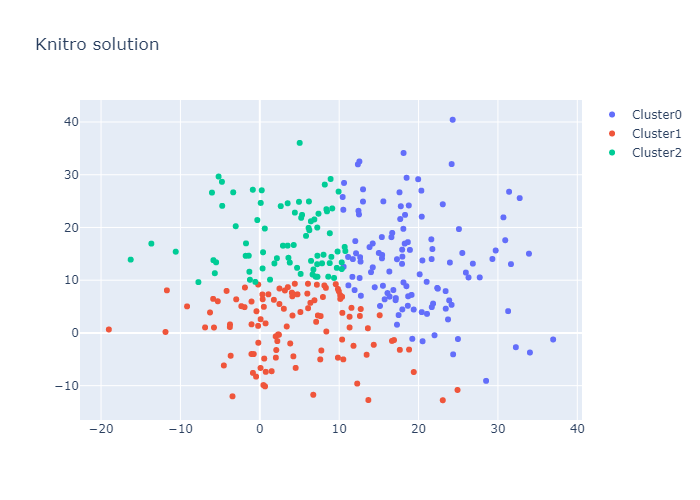

Le cluster 0 admet 114 nombre d'observations
Le cluster 1 admet 109 nombre d'observations
Le cluster 2 admet 77 nombre d'observations
Total cost is 29284.565049818302


In [12]:
draw_figure(nb_observations,nb_clusters,model, "Knitro solution")

## Constrained clustering

### Problem description

Another common case in clustering is to have lower and/or upper bounds on the cluster sizes. This is known as "constrained clustering".

Let $u_{limit} \in \mathbb{R^+}$ be the maximum number of observations in a cluster.

Let $l_{limit} \in \mathbb{R^+}$ be the minimum number of observations in a cluster.

### Input data
To illustrate this, we are going to use some new observations from the `kmeans2.csv` file.
We look to partition these observations into 10 clusters such that the size of each cluster lies between 8 and 12. 

In [13]:
data = pd.read_csv('kmeans2.csv')
print(data)

            X          Y
0    2.072345  -3.241693
1   17.936710  15.784810
2    1.083576   7.319176
3   11.120670  14.406780
4   23.711550   2.557729
..        ...        ...
85   5.987025   7.456533
86  12.639020  14.350810
87   7.392535  22.613040
88  10.372120  -1.258270
89 -19.017910   0.650730

[90 rows x 2 columns]


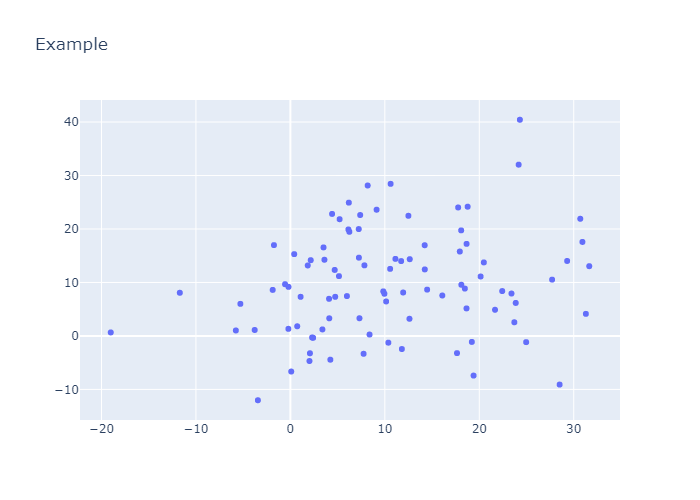

In [14]:
X = data['X'].values
Y = data['Y'].values 
observations_positions = np.array(list(zip(X,Y)))
nb_observations = len(observations_positions)
nb_clusters = 10
draw_data(observations_positions, "Example")

### Resolution without bounds on cluster sizes

Let's solve the problem using the model defined in the previous section. 

In [15]:
model = pyo.ConcreteModel()
build_model(nb_observations,nb_clusters)
solver = pyo.SolverFactory('knitroampl')
results = solver.solve(model, tee=True)

Artelys Knitro 14.1.0: 
          Commercial License
         Artelys Knitro 14.1.0

No start point provided -- Knitro computing one.

         The Knitro mixed integer solver is designed for convex problems.
         For non-convex problems it is only a heuristic, and the reported
         bounds and optimality claims cannot be verified.

concurrent_evals         0
datacheck                0
hessian_no_f             1
hessopt                  1
Knitro changing mip_method from AUTO to 1.
Knitro changing mip_rootalg from AUTO to 1.
Knitro changing mip_lpalg from AUTO to 3.
Knitro changing mip_branchrule from AUTO to 2.
Knitro changing mip_selectrule from AUTO to 2.
Knitro changing mip_mir from AUTO to 2.
Knitro changing mip_clique from AUTO to 0.
Knitro changing mip_zerohalf from AUTO to 0.
Knitro changing mip_liftproject from AUTO to 0.
Knitro changing mip_knapsack from AUTO to 2.
Knitro changing mip_gomory from AUTO to 0.
Knitro changing mip_cut_flowcover from AUTO to 2.
Knitro changi

   70        14420.9      3.76645e-03           25208.9       2.638
   71        14418.8      1.13742e-03       4.06594e+06       2.668
   72        14418.8      1.07098e-03           172.921       3.023
   73        13242.4         0.868647           157.950       3.189
   74        13217.8          5.25498           153.079       3.358
   75        13131.5          2.78094           134.944       3.500
   76        13131.5          2.65961           136.929       3.649
   77        13131.5          2.30245           137.154       3.771
   78        13131.5          2.03465           134.702       3.885
   79        13131.3          1.65997           143.603       4.001
   80        13131.3          1.47960           142.050       4.104
   81        13130.9          1.06277           121.535       4.210
   82        13130.9          1.06276           113.853       4.306
   83        13130.9         0.821636           113.853       4.415
   84        13130.9         0.774977           

  193        7840.94      3.98792e-04           34.7382       9.435
  194        7805.72      3.34551e-03           32.4771       9.471
  195        7725.32      1.21778e-02           18.1527       9.499
  196        7664.64      1.80313e-02           14.0436       9.547
  197        7547.46      4.40901e-02           12.3941       9.581
  198        7456.75      5.99637e-02           12.5081       9.615
  199        7442.31      5.95523e-02           11.7534       9.669
  200        7411.34      5.96736e-02           11.6227       9.702
  201        7387.62      5.74174e-02           11.2895       9.752
  202        7368.43      5.70788e-02           11.1421       9.789
  203        7366.83      5.60359e-02           10.7248       9.845
  204        7365.51      1.08853e-04           11.1011       9.884
  205        7345.74      1.72328e-03           12.5885       9.949
  206        7228.52      3.23988e-02           17.0704       9.996
  207        7177.88      6.37188e-03           

  315        5416.33      1.69998e-02           35.7801      14.753
  316        5412.62      2.01203e-02           254.121      14.797
  317        5408.67      1.84084e-02           211.519      14.822
  318        5400.25      1.81144e-02           254.896      14.848
  319        5396.12      1.73195e-02           188.221      14.901
  320        5393.22      1.73951e-02           149.991      14.928
  321        5389.62      1.02635e-03           7.93627      14.970
  322        5383.59      2.63926e-03           8.69043      15.025
  323        5366.85      1.39765e-02           9.60005      15.057
  324        5353.38      2.05461e-02           11.1638      15.094
  325        5341.94      3.02975e-02           12.9847      15.119
  326        5325.63      3.49361e-02           14.7147      15.155
  327        5305.40      5.83149e-02           17.7654      15.180
  328        5284.59      2.05492e-02           18.8794      15.223
  329        5242.91      6.57867e-02           

  438        4330.09      7.83326e-02           366.326      19.859
  439        4330.05      1.89264e-02           108.056      19.886
  440        4326.20      1.55204e-02           108.179      19.922
  441        4320.43      1.59613e-02           108.332      19.952
  442        4318.47      1.50995e-02           108.332      20.007
  443        4317.40      1.50607e-02           108.325      20.036
  444        4315.82      1.39071e-03           20.5082      20.077
  445        4309.78      1.17145e-02           22.2832      20.130
  446        4306.03      7.23177e-03           23.7589      20.174
  447        4301.24      6.53492e-03           25.3838      20.226
  448        4285.92      2.69915e-02           29.7264      20.264
  449        4273.16      3.15746e-02           32.5871      20.314
  450        4264.06      3.64333e-02           34.2375      20.349
  451        4258.06      3.19953e-02           35.6320      20.410
  452        4232.10      7.40402e-02           

  563        3307.23      8.23838e-03           15.5256      25.439
  564        3306.57      8.27882e-03           2.66817      25.508
  565        3284.48         0.155218           4.34641      25.558
  566        3269.96         0.141183           8.56091      25.624
  567        3267.92         0.135484           8.40340      25.674
  568        3264.94         0.120947           8.07972      25.742
  569        3226.35         0.211901           11.0902      25.791
  570        3217.49      3.36413e-02           12.1878      25.847
  571        3214.78      3.03914e-03           12.2639      25.924
  572        3205.52      2.52122e-02           5.33410      25.975
  573        3192.82      5.92602e-02           6.20606      26.045
  574        3192.96      9.50458e-05           6.17224      26.097
  575        3190.88      2.43557e-03           5.71269      26.161
  576        3183.36      5.01461e-02           5.39369      26.204
  577        3173.62      4.68054e-02           

  687        2530.21      1.33104e-02          0.834156      30.979
  688        2517.56         0.129336           5.07580      31.008
  689        2498.15         0.322598           11.1120      31.039
  690        2477.71         0.259811           11.7255      31.082
  691        2479.79      7.83034e-04           11.7644      31.115
  692        2458.05         0.592248           7.39155      31.145
  693        2460.01      1.63490e-02           7.39290      31.178
  694        2456.07      3.48323e-02           7.39513      31.220
  695        2450.35      5.33256e-02           7.41887      31.253
  696        2440.43      8.55719e-02           9.97566      31.301
  697        2440.38      3.99797e-04           6.95935      31.336
  698        2417.04          2.85572           21.3508      31.381
  699        2409.42          2.68303           19.0577      31.410
  700        2414.28          3.07190           2.19260      31.440
  701        2393.00          2.14468           

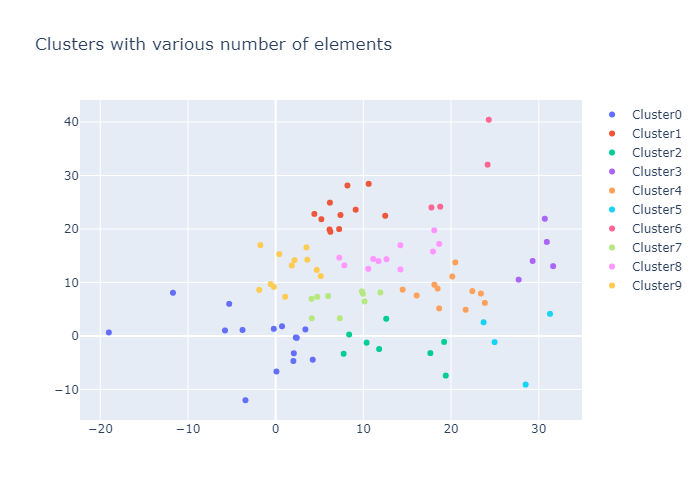

Le cluster 0 admet 15 nombre d'observations
Le cluster 1 admet 11 nombre d'observations
Le cluster 2 admet 8 nombre d'observations
Le cluster 3 admet 5 nombre d'observations
Le cluster 4 admet 11 nombre d'observations
Le cluster 5 admet 4 nombre d'observations
Le cluster 6 admet 4 nombre d'observations
Le cluster 7 admet 9 nombre d'observations
Le cluster 8 admet 11 nombre d'observations
Le cluster 9 admet 12 nombre d'observations
Total cost is 2370.2035561306925


In [16]:
draw_figure(nb_observations,nb_clusters,model, "Clusters with various number of elements")

In this case, some clusters have less observations (or more observations) than required. We need to add new constraints to the model in order to take into account the limits on the number of observations in each cluster.

### Mathematical formulation

We add the two following set of constraints to the previous mathematical model.

* Cluster size upper bound

$$
\forall k = 1, \dots, K, \qquad \sum_{i=1}^N {a^k_i} \leq u_{limit}
$$

* Cluster size lower bound

$$
\forall k = 1, \dots, K, \qquad \sum_{i=1}^N {a^k_i} \geq l_{limit}
$$

### Implementation with Pyomo

In [17]:
def size_upper_clusters_rule(model,j):
    total = sum(model.a[i,j] for i in range(nb_observations))
    return (total <= 12)
model.constraints_size_upper_clusters = pyo.Constraint(model.K,rule=size_upper_clusters_rule)

def size_lower_clusters_rule(model,j):
    total = sum(model.a[i,j] for i in range(nb_observations))
    return (total >= 8)
model.constraints_size_lower_clusters = pyo.Constraint(model.K,rule=size_lower_clusters_rule)

results = solver.solve(model, tee=True)

Artelys Knitro 14.1.0: 
          Commercial License
         Artelys Knitro 14.1.0

         The Knitro mixed integer solver is designed for convex problems.
         For non-convex problems it is only a heuristic, and the reported
         bounds and optimality claims cannot be verified.

concurrent_evals         0
datacheck                0
hessian_no_f             1
hessopt                  1
Knitro changing mip_method from AUTO to 1.
Knitro changing mip_rootalg from AUTO to 1.
Knitro changing mip_lpalg from AUTO to 3.
Knitro changing mip_branchrule from AUTO to 2.
Knitro changing mip_selectrule from AUTO to 2.
Knitro changing mip_mir from AUTO to 2.
Knitro changing mip_clique from AUTO to 0.
Knitro changing mip_zerohalf from AUTO to 0.
Knitro changing mip_liftproject from AUTO to 0.
Knitro changing mip_knapsack from AUTO to 2.
Knitro changing mip_gomory from AUTO to 0.
Knitro changing mip_cut_flowcover from AUTO to 2.
Knitro changing mip_cut_probing from AUTO to 1.
Knitro changing

   70        10956.1          1.32962           19.3760       2.671
   71        10970.3          1.19115           19.1802       2.698
   72        11008.7          1.16941           18.6445       2.739
   73        11050.0          1.16651           18.4390       2.768
   74        11063.9          1.15174           18.4547       2.797
   75        11133.2          1.11884           18.3280       2.847
   76        11193.9          1.11264           18.3587       2.882
   77        11216.4          1.10841           18.4758       2.917
   78        11282.0          1.10212           18.4446       2.967
   79        11296.9          1.09951           18.4948       3.001
   80        11350.9          1.09491           18.4281       3.049
   81        11366.3          1.09282           18.4683       3.083
   82        11374.6          1.09015           18.5654       3.120
   83        11405.7          1.08693           18.6307       3.171
   84        11416.1          1.08414           

### Output visualization

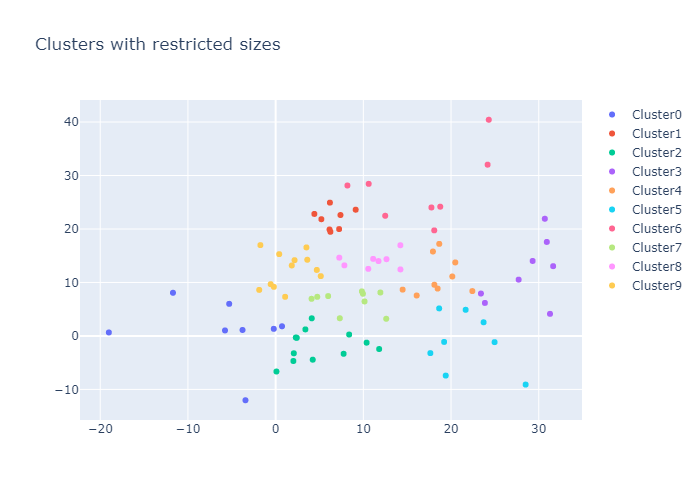

Le cluster 0 admet 8 nombre d'observations
Le cluster 1 admet 8 nombre d'observations
Le cluster 2 admet 12 nombre d'observations
Le cluster 3 admet 8 nombre d'observations
Le cluster 4 admet 9 nombre d'observations
Le cluster 5 admet 8 nombre d'observations
Le cluster 6 admet 8 nombre d'observations
Le cluster 7 admet 9 nombre d'observations
Le cluster 8 admet 8 nombre d'observations
Le cluster 9 admet 12 nombre d'observations
Total cost is 2477.423632825829


In [18]:
draw_figure(nb_observations,nb_clusters,model,"Clusters with restricted sizes")

The constraints are satisfied, we can observe that each cluster has a number of observations between 8 and 12. 